In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-azure-predictive-maintenance/PdM_errors.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_telemetry.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_failures.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_machines.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_maint.csv


# Importing necessary libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_mach=pd.read_csv("/kaggle/input/microsoft-azure-predictive-maintenance/PdM_machines.csv")
tele=pd.read_csv("/kaggle/input/microsoft-azure-predictive-maintenance/PdM_telemetry.csv")
fail=pd.read_csv("/kaggle/input/microsoft-azure-predictive-maintenance/PdM_failures.csv")
maint=pd.read_csv("/kaggle/input/microsoft-azure-predictive-maintenance/PdM_maint.csv")
error=pd.read_csv("/kaggle/input/microsoft-azure-predictive-maintenance/PdM_errors.csv")

# Exploring all datasets

In [4]:
df_mach.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [5]:
tele.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [6]:
fail.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [7]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [8]:
error.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [9]:
tele['datetime']=pd.to_datetime(tele['datetime'])
maint['datetime']=pd.to_datetime(maint['datetime'])
fail['datetime']=pd.to_datetime(fail['datetime'])
error['datetime']=pd.to_datetime(error['datetime'])


In [10]:
fail['failure']=1

In [11]:
error['error_count']=1

In [12]:
error_agg=error.groupby(['machineID','datetime']).size().reset_index(name='error_count')
error_agg

,machineID,datetime,error_count
0,1,2015-01-03 07:00:00,1
1,1,2015-01-03 20:00:00,1
2,1,2015-01-04 06:00:00,1
3,1,2015-01-10 15:00:00,1
4,1,2015-01-22 10:00:00,1
...,...,...,...
3611,100,2015-11-12 01:00:00,1
3612,100,2015-11-21 08:00:00,1
3613,100,2015-12-04 02:00:00,1
3614,100,2015-12-08 06:00:00,2


In [13]:
maint['maint_comp']=maint['comp']

# Objective 

Predict the remaining useful life (RUL) or time until the next failure for each machine or How long will the machine work until failure?


# Merging datasets

In [14]:
df1=pd.merge(tele,df_mach,on='machineID',how='left')
df1.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18


In [15]:
df2=pd.merge_asof(df1.sort_values('datetime'),
                  error_agg.sort_values('datetime'),
                  by='machineID',
                  on='datetime',
                  direction='backward'
                 )
df2

,datetime,machineID,volt,rotate,pressure,vibration,model,age,error_count
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN
1,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,model3,5,NaN
2,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,model1,14,NaN
3,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,model3,9,NaN
4,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,model3,7,NaN
...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 06:00:00,70,188.135372,457.661580,89.725251,42.932201,model3,9,1.0
876096,2016-01-01 06:00:00,71,174.028202,349.326013,111.231561,38.669674,model2,18,1.0
876097,2016-01-01 06:00:00,72,183.176861,381.242172,104.658441,38.504998,model4,2,1.0
876098,2016-01-01 06:00:00,74,188.299688,494.616310,101.785150,41.609665,model4,4,1.0


In [16]:
df3=pd.merge_asof(df2.sort_values('datetime'),
                 maint.sort_values('datetime'),
                 by='machineID',
                 on='datetime',
                 direction='backward')
df3

,datetime,machineID,volt,rotate,pressure,vibration,model,age,error_count,comp,maint_comp
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN,comp1,comp1
1,2015-01-01 06:00:00,50,174.107006,380.449983,100.749836,43.185498,model4,4,NaN,comp1,comp1
2,2015-01-01 06:00:00,60,172.394188,394.464191,103.233454,39.144937,model4,3,NaN,comp4,comp4
3,2015-01-01 06:00:00,31,174.475535,483.608665,107.143516,31.630132,model1,11,NaN,comp3,comp3
4,2015-01-01 06:00:00,78,168.664547,504.012527,94.782861,42.962420,model4,19,NaN,comp3,comp3
...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 06:00:00,1,191.873171,382.736626,100.893691,37.940220,model3,18,1.0,comp1,comp1
876096,2016-01-01 06:00:00,22,169.744691,459.621105,100.110835,43.578150,model1,14,1.0,comp3,comp3
876097,2016-01-01 06:00:00,24,187.324623,372.785606,109.024934,37.397309,model1,20,1.0,comp3,comp3
876098,2016-01-01 06:00:00,9,176.007480,414.778970,93.243580,37.594398,model4,7,1.0,comp1,comp1


In [17]:
df4=pd.merge_asof(df3.sort_values('datetime'),
                 fail.sort_values('datetime'),
                 by='machineID',
                 on='datetime',
                 direction='forward')
df4

,datetime,machineID,volt,rotate,pressure,vibration,model,age,error_count,comp,maint_comp,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN,comp1,comp1,1.0
1,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,model3,5,NaN,comp4,comp4,1.0
2,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,model1,14,NaN,comp2,comp2,1.0
3,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,model3,9,NaN,comp1,comp1,1.0
4,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,model3,7,NaN,comp1,comp1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 06:00:00,70,188.135372,457.661580,89.725251,42.932201,model3,9,1.0,comp4,comp4,NaN
876096,2016-01-01 06:00:00,71,174.028202,349.326013,111.231561,38.669674,model2,18,1.0,comp3,comp3,NaN
876097,2016-01-01 06:00:00,48,183.822000,410.036090,100.201486,41.777284,model4,10,1.0,comp2,comp2,NaN
876098,2016-01-01 06:00:00,49,181.656293,423.439324,112.353263,29.728374,model1,15,1.0,comp4,comp4,NaN


In [18]:
df4.isnull().sum()

datetime            0
machineID           0
volt                0
rotate              0
pressure            0
vibration           0
model               0
age                 0
error_count     21146
comp                0
maint_comp          0
failure        120746
dtype: int64

In [19]:
df4['error_count']=df4['error_count'].fillna(0)
df4['failure']=df4['failure'].fillna(0)

In [20]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     876100 non-null  datetime64[ns]
 1   machineID    876100 non-null  int64         
 2   volt         876100 non-null  float64       
 3   rotate       876100 non-null  float64       
 4   pressure     876100 non-null  float64       
 5   vibration    876100 non-null  float64       
 6   model        876100 non-null  object        
 7   age          876100 non-null  int64         
 8   error_count  876100 non-null  float64       
 9   comp         876100 non-null  object        
 10  maint_comp   876100 non-null  object        
 11  failure      876100 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(3)
memory usage: 80.2+ MB


In [21]:
df4['failure']=df4['failure'].astype(int)

# Calculating the remaining useful life

In [22]:
failure_data=df4[df4['failure']==1]

fail_timestamp=failure_data.groupby('machineID')['datetime'].min().reset_index(name='failure_datetime')
fail_timestamp

,machineID,failure_datetime
0,1,2015-01-01 06:00:00
1,2,2015-01-01 06:00:00
2,3,2015-01-01 06:00:00
3,4,2015-01-01 06:00:00
4,5,2015-01-01 06:00:00
...,...,...
93,96,2015-01-01 06:00:00
94,97,2015-01-01 06:00:00
95,98,2015-01-01 06:00:00
96,99,2015-01-01 06:00:00


In [23]:
df = pd.merge(df4, fail_timestamp, on='machineID', how='left')
df

,datetime,machineID,volt,rotate,pressure,vibration,model,age,error_count,comp,maint_comp,failure,failure_datetime
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,0.0,comp1,comp1,1,2015-01-01 06:00:00
1,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,model3,5,0.0,comp4,comp4,1,2015-01-01 06:00:00
2,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,model1,14,0.0,comp2,comp2,1,2015-01-01 06:00:00
3,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,model3,9,0.0,comp1,comp1,1,2015-01-01 06:00:00
4,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,model3,7,0.0,comp1,comp1,0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 06:00:00,70,188.135372,457.661580,89.725251,42.932201,model3,9,1.0,comp4,comp4,0,2015-01-01 06:00:00
876096,2016-01-01 06:00:00,71,174.028202,349.326013,111.231561,38.669674,model2,18,1.0,comp3,comp3,0,2015-01-01 06:00:00
876097,2016-01-01 06:00:00,48,183.822000,410.036090,100.201486,41.777284,model4,10,1.0,comp2,comp2,0,2015-01-01 06:00:00
876098,2016-01-01 06:00:00,49,181.656293,423.439324,112.353263,29.728374,model1,15,1.0,comp4,comp4,0,2015-01-01 06:00:00


In [24]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['failure_datetime'] = pd.to_datetime(df['failure_datetime'])

In [25]:
df['rul']=df['datetime']- df['failure_datetime']#covert to hour
df['rul']=df['rul'].dt.total_seconds() / 3600

In [26]:
df

,datetime,machineID,volt,rotate,pressure,vibration,model,age,error_count,comp,maint_comp,failure,failure_datetime,rul
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,0.0,comp1,comp1,1,2015-01-01 06:00:00,0.0
1,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,model3,5,0.0,comp4,comp4,1,2015-01-01 06:00:00,0.0
2,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,model1,14,0.0,comp2,comp2,1,2015-01-01 06:00:00,0.0
3,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,model3,9,0.0,comp1,comp1,1,2015-01-01 06:00:00,0.0
4,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,model3,7,0.0,comp1,comp1,0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 06:00:00,70,188.135372,457.661580,89.725251,42.932201,model3,9,1.0,comp4,comp4,0,2015-01-01 06:00:00,8760.0
876096,2016-01-01 06:00:00,71,174.028202,349.326013,111.231561,38.669674,model2,18,1.0,comp3,comp3,0,2015-01-01 06:00:00,8760.0
876097,2016-01-01 06:00:00,48,183.822000,410.036090,100.201486,41.777284,model4,10,1.0,comp2,comp2,0,2015-01-01 06:00:00,8760.0
876098,2016-01-01 06:00:00,49,181.656293,423.439324,112.353263,29.728374,model1,15,1.0,comp4,comp4,0,2015-01-01 06:00:00,8760.0


### For machines where failure is 0:- 
- Let us assume that the machine will work(failure datetime) until the last timestamp of this dataset(datetime.max()), and 
- the missing RUL will be **df['datetime'].max() - df['datetime']).dt.total_seconds() / 3600**  (in hrs)

In [27]:
maxtime=df['datetime'].max()
rul=maxtime-df['datetime']
df['failure_datetime']=df['failure_datetime'].fillna(maxtime)
df['rul']=df['rul'].fillna(rul.dt.total_seconds()/3600)

### Categorical to Numerical

In [28]:
df_num=pd.get_dummies(df,columns=['model','comp','maint_comp'],drop_first=True,dtype=int)

In [29]:
df_num

,datetime,machineID,volt,rotate,pressure,vibration,age,error_count,failure,failure_datetime,rul,model_model2,model_model3,model_model4,comp_comp2,comp_comp3,comp_comp4,maint_comp_comp2,maint_comp_comp3,maint_comp_comp4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0.0,1,2015-01-01 06:00:00,0.0,0,1,0,0,0,0,0,0,0
1,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,5,0.0,1,2015-01-01 06:00:00,0.0,0,1,0,0,0,1,0,0,1
2,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,14,0.0,1,2015-01-01 06:00:00,0.0,0,0,0,1,0,0,1,0,0
3,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,9,0.0,1,2015-01-01 06:00:00,0.0,0,1,0,0,0,0,0,0,0
4,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,7,0.0,0,2016-01-01 06:00:00,8760.0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 06:00:00,70,188.135372,457.661580,89.725251,42.932201,9,1.0,0,2015-01-01 06:00:00,8760.0,0,1,0,0,0,1,0,0,1
876096,2016-01-01 06:00:00,71,174.028202,349.326013,111.231561,38.669674,18,1.0,0,2015-01-01 06:00:00,8760.0,1,0,0,0,1,0,0,1,0
876097,2016-01-01 06:00:00,48,183.822000,410.036090,100.201486,41.777284,10,1.0,0,2015-01-01 06:00:00,8760.0,0,0,1,1,0,0,1,0,0
876098,2016-01-01 06:00:00,49,181.656293,423.439324,112.353263,29.728374,15,1.0,0,2015-01-01 06:00:00,8760.0,0,0,0,0,0,1,0,0,1


In [30]:
# df['failure'].value_counts()

# Visualization

### Correlation

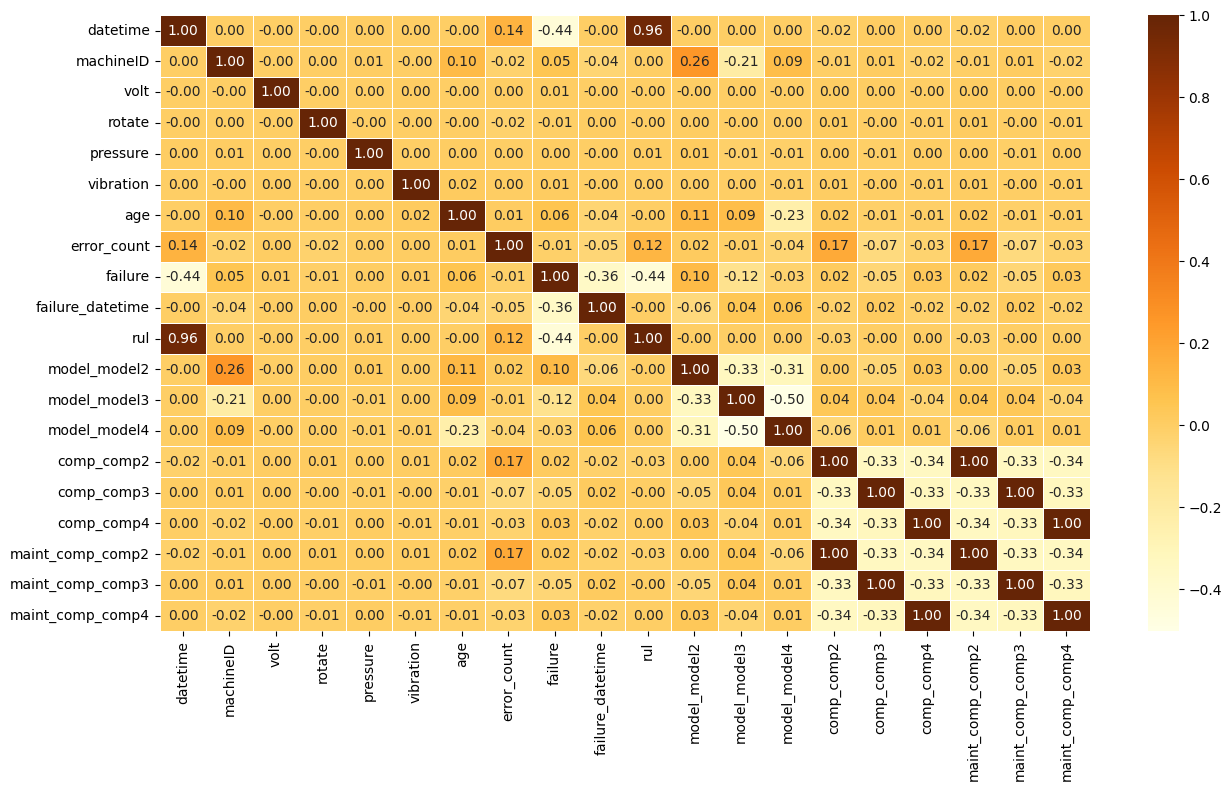

In [31]:
plt.figure(figsize=(15, 8)) 
sns.heatmap(df_num.corr(), cmap="YlOrBr", linewidths=0.4, fmt=".2f", linecolor="white", annot=True)
plt.show()

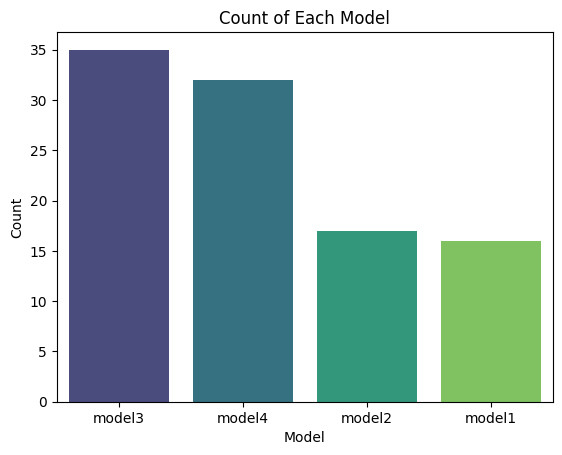

In [32]:
model_counts = df_mach['model'].value_counts().reset_index()
sns.barplot(data=model_counts, x='model', y='count', palette='viridis')
plt.title('Count of Each Model')
plt.xlabel('Model')
plt.ylabel('Count')
plt.show()

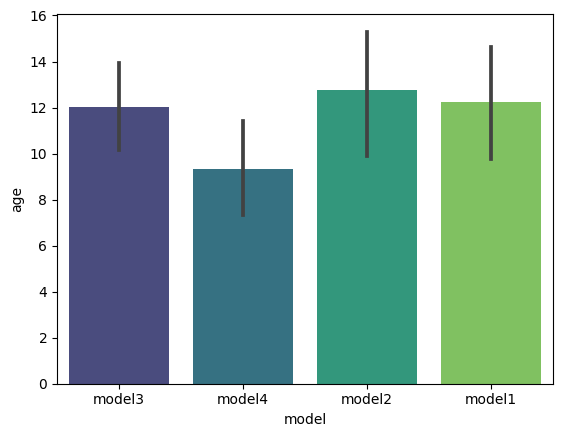

In [33]:
sns.barplot(data=df_mach,x='model',y='age',palette='viridis')
# plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


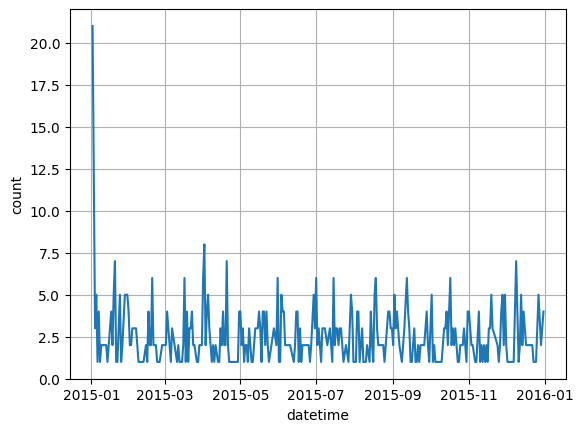

In [34]:
fail['datetime']=pd.to_datetime(fail['datetime']).dt.date
fail_per_day=fail.groupby('datetime').size().reset_index(name='count')
fail_per_day = fail_per_day.sort_values(by="datetime")
sns.lineplot(data=fail_per_day, x="datetime", y="count")
plt.grid(True)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


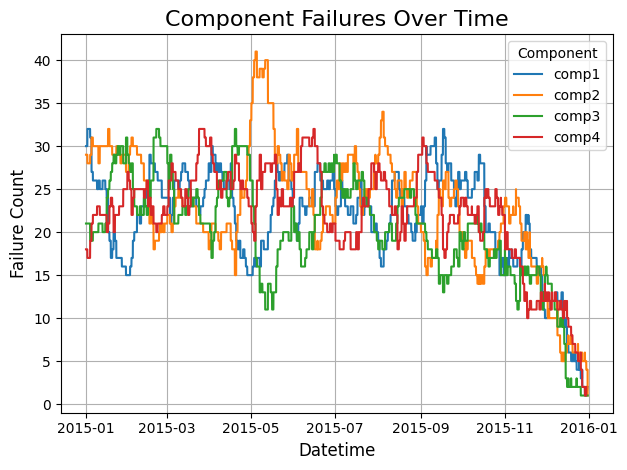

In [35]:
failure_count = (failure_data.groupby(['datetime', 'comp']).size().reset_index(name='Count'))
sns.lineplot(data=failure_count, x='datetime', y='Count', hue='comp', palette='tab10')

plt.title('Component Failures Over Time', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Failure Count', fontsize=12)
plt.legend(title='Component', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

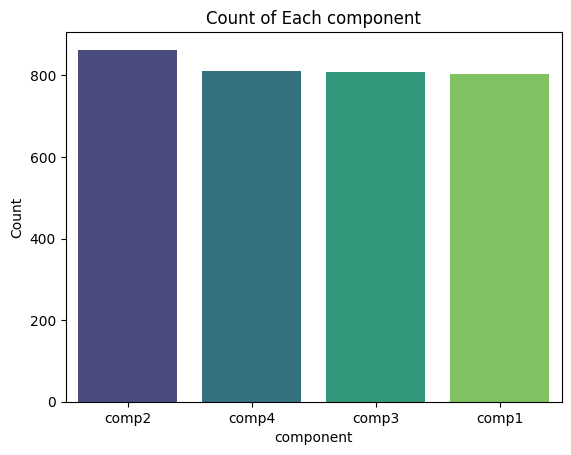

In [36]:
ccount=maint['comp'].value_counts().reset_index()
sns.barplot(data=ccount, x='comp', y='count', palette='viridis')
plt.title('Count of Each component')
plt.xlabel('component')
plt.ylabel('Count')
plt.show()

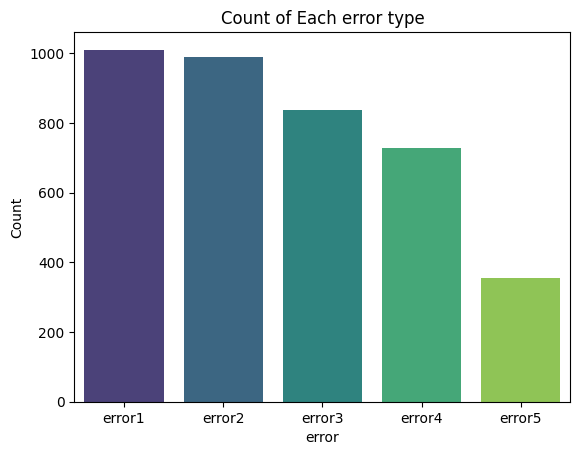

In [37]:
cerror=error['errorID'].value_counts().reset_index()
sns.barplot(data=cerror, x='errorID', y='count', palette='viridis')
plt.title('Count of Each error type')
plt.xlabel('error')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

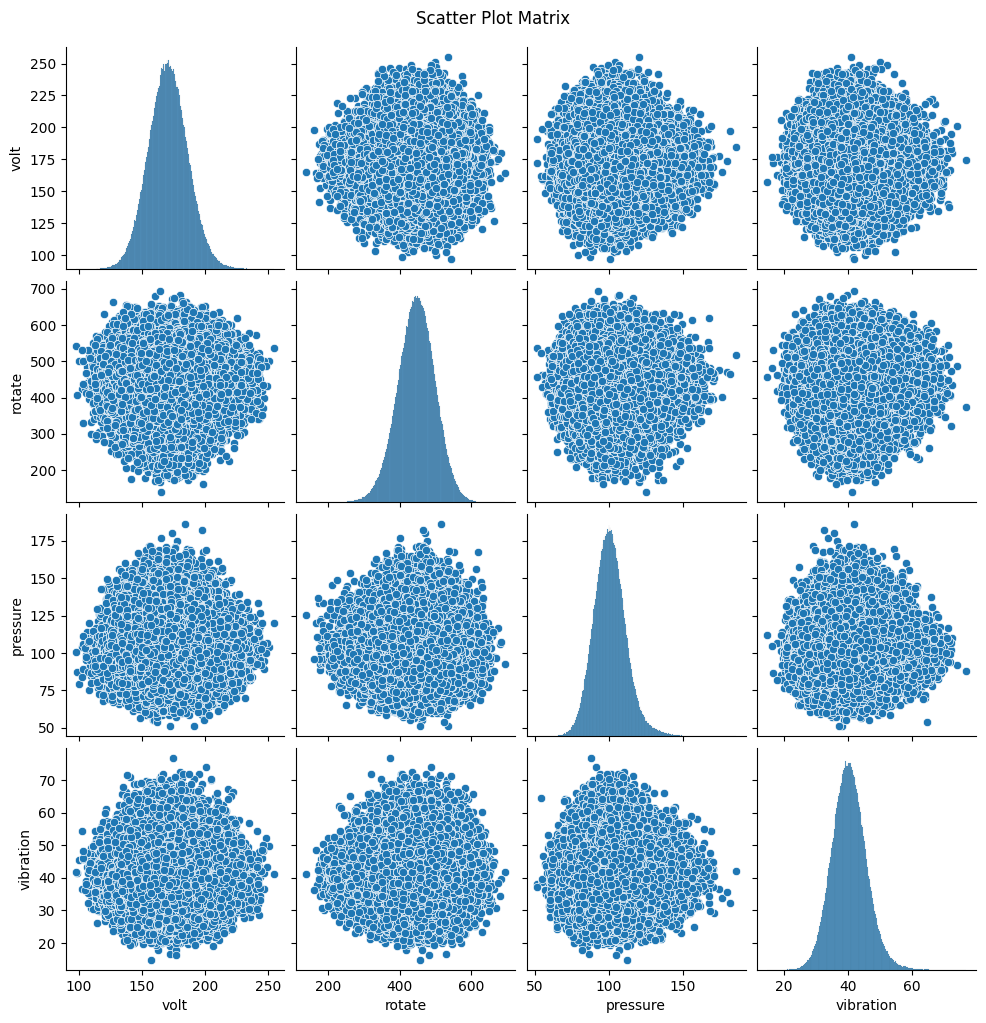

In [38]:
sns.pairplot(df[["volt", "rotate", "pressure", "vibration"]])
plt.suptitle("Scatter Plot Matrix", y=1.02)
plt.show()


# Model Building

### extracting from datetime

In [39]:
df_num['year']=df['datetime'].dt.year
df_num['day']=df['datetime'].dt.day
df_num['month']=df['datetime'].dt.month
df_num['hour']=df['datetime'].dt.hour
df_num['fail_year']=df['failure_datetime'].dt.year
df_num['fail_day']=df['failure_datetime'].dt.day
df_num['fail_month']=df['failure_datetime'].dt.month
df_num['fail_hour']=df['failure_datetime'].dt.hour

df_num=df_num.drop(columns=['datetime','failure_datetime'])

In [40]:
st=StandardScaler()

In [41]:
df_num

,machineID,volt,rotate,pressure,vibration,age,error_count,failure,rul,model_model2,...,maint_comp_comp3,maint_comp_comp4,year,day,month,hour,fail_year,fail_day,fail_month,fail_hour
0,1,176.217853,418.504078,113.077935,45.087686,18,0.0,1,0.0,0,...,0,0,2015,1,1,6,2015,1,1,6
1,53,183.084582,420.980061,109.235805,45.737760,5,0.0,1,0.0,0,...,0,1,2015,1,1,6,2015,1,1,6
2,99,168.596133,384.747105,110.921131,41.944692,14,0.0,1,0.0,0,...,0,0,2015,1,1,6,2015,1,1,6
3,12,171.404215,576.923563,97.145400,47.725909,9,0.0,1,0.0,0,...,0,0,2015,1,1,6,2015,1,1,6
4,6,136.878588,492.088420,149.003582,22.973289,7,0.0,0,8760.0,0,...,0,0,2015,1,1,6,2016,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876095,70,188.135372,457.661580,89.725251,42.932201,9,1.0,0,8760.0,0,...,0,1,2016,1,1,6,2015,1,1,6
876096,71,174.028202,349.326013,111.231561,38.669674,18,1.0,0,8760.0,1,...,1,0,2016,1,1,6,2015,1,1,6
876097,48,183.822000,410.036090,100.201486,41.777284,10,1.0,0,8760.0,0,...,0,0,2016,1,1,6,2015,1,1,6
876098,49,181.656293,423.439324,112.353263,29.728374,15,1.0,0,8760.0,0,...,0,1,2016,1,1,6,2015,1,1,6


In [42]:
X=df_num.drop('rul',axis=1)
y=df_num['rul']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
X_train_scaled=st.fit_transform(X_train)
X_test_scaled=st.fit_transform(X_test)

In [46]:
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],)))  # Automatically considers the number of features in X_train
model.add(Dense(15, activation='relu'))
model.add(Dense(1))

In [47]:
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [48]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,     
    restore_best_weights=True 
)

In [70]:
epochs = 20

In [71]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=epochs,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
21903/21903 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 160695.7656 - mae: 122.4667 - val_loss: 107016.2188 - val_mae: 103.4020
Epoch 2/20
21903/21903 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 93024.3359 - mae: 98.7340 - val_loss: 52987.8438 - val_mae: 88.2622
Epoch 3/20
21903/21903 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 41917.5703 - mae: 84.6200 - val_loss: 19609.9863 - val_mae: 74.0626
Epoch 4/20
21903/21903 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 15367.8516 - mae: 68.6141 - val_loss: 6555.8076 - val_mae: 51.5315
Epoch 5/20
21903/21903 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 4926.9590 - mae: 45.7503 - val_loss: 2416.5078 - val_mae: 30.9205
Epoch 6/20
21903/21903 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 1792.4806 - mae: 27.9351 - val_loss: 1439.1062 - val_mae: 24.8710
Epoch 7/20
21903/21903 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 1142.7439 - mae: 23.0560 - val_loss: 1040.6860 - val_mae: 22.2184
Epoch 8/20
21903/21903 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 852.552

In [72]:
loss,mae=model.evaluate(X_test_scaled,y_test,verbose=1)
print(f"Test loss{loss},Test Mae:{mae}")

5476/5476 ━━━━━━━━━━━━━━━━━━━━ 5s 908us/step - loss: 214.0665 - mae: 10.6227
Test loss221.57765197753906,Test Mae:10.675471305847168


In [73]:
predictions=model.predict(X_test_scaled)

5476/5476 ━━━━━━━━━━━━━━━━━━━━ 5s 931us/step


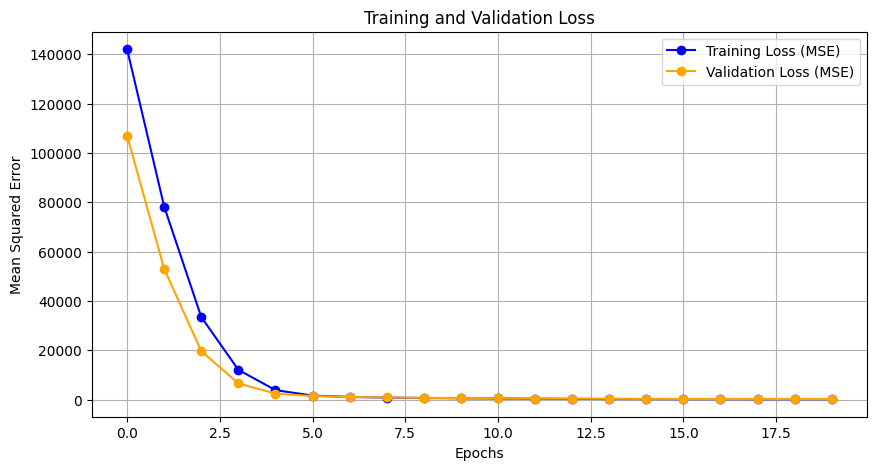

In [74]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_mae=history.history['mae']
val_mae=history.history['val_mae']


plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss (MSE)', color='blue', marker='o')
plt.plot(val_loss, label='Validation Loss (MSE)', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


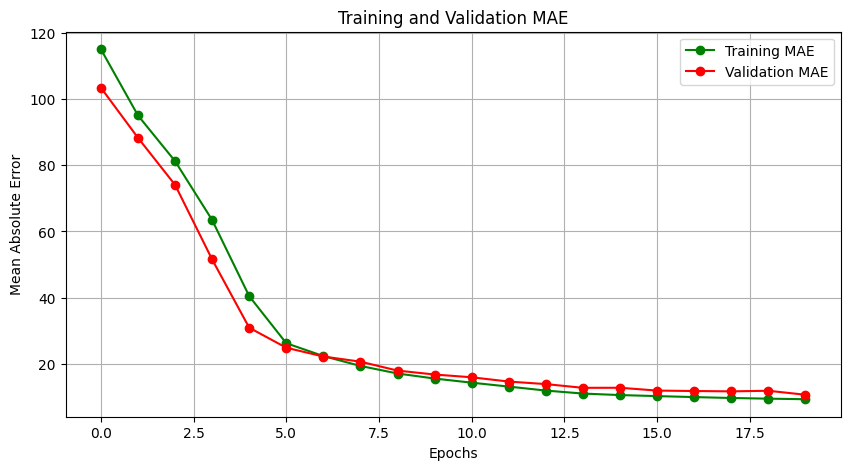

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(train_mae, label='Training MAE', color='green', marker='o')
plt.plot(val_mae, label='Validation MAE', color='red', marker='o')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
!pip install mlflow

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [77]:
import os
import mlflow
import mlflow.tensorflow
from mlflow.models import infer_signature

os.environ["MLFLOW_TRACKING_USERNAME"] = "admin"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "abcdef123456!"

mlflow.set_tracking_uri("http://a86fe38cbd0214348a9553cebf3cbb64-1653838400.us-east-1.elb.amazonaws.com")
mlflow.set_experiment("RULPredictionExperiment1000")

2025/09/12 19:38:02 INFO mlflow.tracking.fluent: Experiment with name 'RULPredictionExperiment1000' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/14', creation_time=1757705882430, experiment_id='14', last_update_time=1757705882430, lifecycle_stage='active', name='RULPredictionExperiment1000', tags={}>

In [78]:
signature = infer_signature(X_test_scaled, predictions)

with mlflow.start_run():
    info = mlflow.tensorflow.log_model(model, name="model", signature=signature, registered_model_name="RULPrediction1000" )
    mlflow.log_param("epochs", epochs)
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("mae", mae)

    print("artifact_uri:", mlflow.get_artifact_uri())
    print("model_uri:", info.model_uri)

Successfully registered model 'RULPrediction1000'.
2025/09/12 19:38:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RULPrediction1000, version 1
Created version '1' of model 'RULPrediction1000'.


artifact_uri: mlflow-artifacts:/14/b14f369d0fbd4f95b77eef096ca6bc1b/artifacts
model_uri: models:/m-7c267c79d9734c9aa6a2acd06c0619f0
🏃 View run stylish-kit-747 at: http://a86fe38cbd0214348a9553cebf3cbb64-1653838400.us-east-1.elb.amazonaws.com/#/experiments/14/runs/b14f369d0fbd4f95b77eef096ca6bc1b
🧪 View experiment at: http://a86fe38cbd0214348a9553cebf3cbb64-1653838400.us-east-1.elb.amazonaws.com/#/experiments/14


In [79]:
loaded_model = mlflow.pyfunc.load_model("models:/RULPrediction1000/1")

preds = loaded_model.predict(X_test_scaled)
print(preds)

5476/5476 ━━━━━━━━━━━━━━━━━━━━ 5s 893us/step
[[3392.436 ]
 [1034.613 ]
 [5348.928 ]
 ...
 [8283.773 ]
 [2677.3108]
 [1738.0681]]


In [80]:
len(X_test_scaled)

175220

In [81]:
X_test_scaled_short = X_test_scaled[:5]
print(X_test_scaled_short)

[[ 0.74639917  1.71561978  1.88322633 -0.30672132 -0.65906881 -1.59822688
  -0.18549108  0.40067865 -0.45048679 -0.7330724   1.45115695  1.6812743
  -0.56197962 -0.57803563  1.6812743  -0.56197962 -0.57803563 -0.02917333
   0.7138904  -0.44206462  0.36604155 -0.14338868  0.          0.
   0.        ]
 [-1.16233134  0.91778687 -1.9654746   1.08864256 -0.68006721  0.45773334
  -0.18549108  0.40067865 -0.45048679 -0.7330724  -0.68910534 -0.59478694
  -0.56197962  1.72999716 -0.59478694 -0.56197962  1.72999716 -0.02917333
  -0.19439708 -1.31254856 -0.93421885 -0.14338868  0.          0.
   0.        ]
 [ 0.53817403 -0.74907903  1.88965276 -1.28532475 -0.56549519 -0.91290681
  -0.18549108  0.40067865 -0.45048679 -0.7330724   1.45115695 -0.59478694
  -0.56197962  1.72999716 -0.59478694 -0.56197962  1.72999716 -0.02917333
  -0.53500489  0.42841932  0.94393506 -0.14338868  0.          0.
   0.        ]
 [ 0.29524469 -0.75962859 -0.82899489  0.44905131  0.53891145  0.9717234
  -0.18549108  0.40

In [82]:
preds = loaded_model.predict(X_test_scaled_short)
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[3392.436 ]
 [1034.613 ]
 [5348.928 ]
 [2154.1113]
 [5607.7734]]
